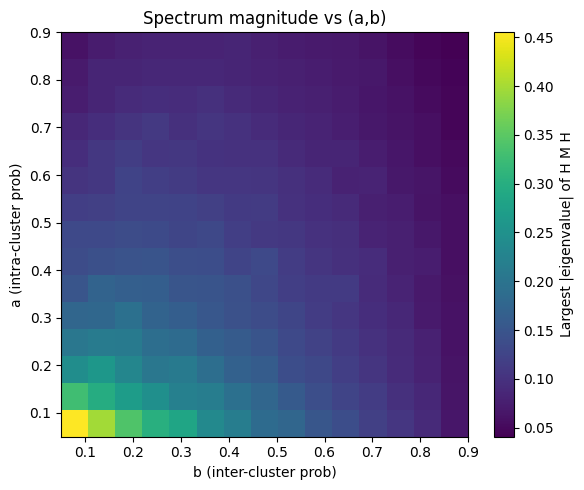

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals

def largest_HMH_eig(n0, n1, a, b, sparse=False):
    n = n0 + n1
    # --- adjacency matrix ---
    scale = 1.0 if not sparse else 1.0 / n
    A = np.zeros((n, n))
    A[:n0, :n0] = (np.random.rand(n0, n0) < a * scale).astype(float)
    A[n0:, n0:] = (np.random.rand(n1, n1) < a * scale).astype(float)
    A[:n0, n0:] = (np.random.rand(n0, n1) < b * scale).astype(float)
    A[n0:, :n0] = A[:n0, n0:].T
    np.fill_diagonal(A, 0)

    # --- normalize ---
    deg = A.sum(axis=1)
    D_inv = np.diag(1.0 / np.maximum(deg, 1e-8))
    M = D_inv @ A

    # --- projection H ---
    ind0 = np.concatenate([np.ones(n0), np.zeros(n1)])
    ind1 = 1 - ind0
    H = np.eye(n) - np.outer(ind0, ind0) / n0 - np.outer(ind1, ind1) / n1

    # --- compute ---
    HMH = H @ M @ H
    eigs = eigvals(HMH)
    return np.max(np.abs(eigs))

# --- parameters ---
n0 = n1 = 100
a_vals = np.linspace(0.05, 0.9, 15)
b_vals = np.linspace(0.05, 0.9, 15)
Z = np.zeros((len(a_vals), len(b_vals)))

for i, a in enumerate(a_vals):
    for j, b in enumerate(b_vals):
        Z[i, j] = largest_HMH_eig(n0, n1, a, b)

# --- plot ---
plt.figure(figsize=(6,5))
plt.imshow(Z, origin='lower', extent=[b_vals[0], b_vals[-1], a_vals[0], a_vals[-1]],
           aspect='auto', cmap='viridis')
plt.colorbar(label='Largest |eigenvalue| of H M H')
plt.xlabel('b (inter-cluster prob)')
plt.ylabel('a (intra-cluster prob)')
plt.title('Spectrum magnitude vs (a,b)')
plt.tight_layout()
plt.show()

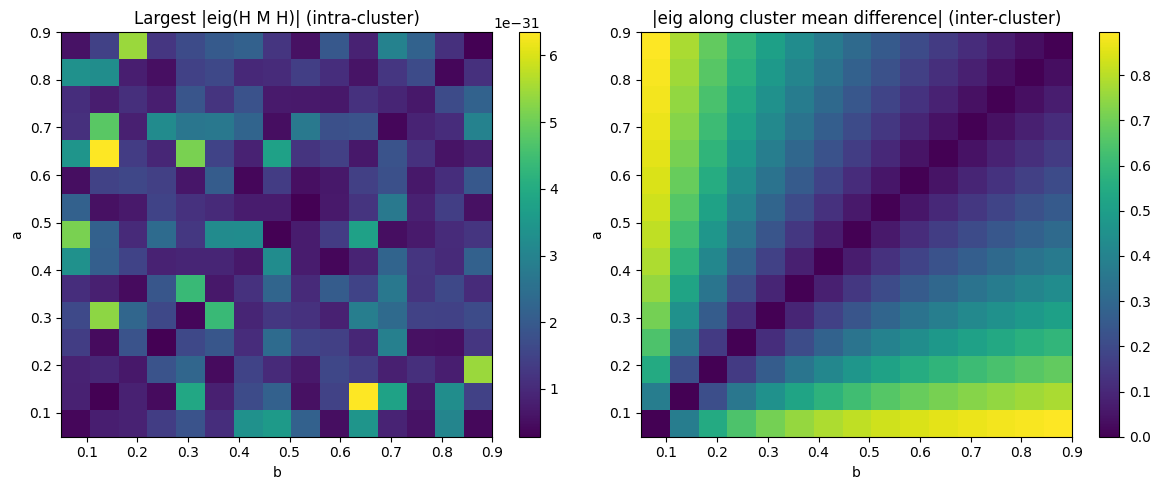

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals

def compute_eigenvalues(n0, n1, a, b):
    n = n0 + n1
    # Adjacency
    A = np.zeros((n, n))
    A[:n0, :n0] = a
    A[n0:, n0:] = a
    A[:n0, n0:] = b
    A[n0:, :n0] = b

    # Random-walk normalization
    deg = A.sum(axis=1)
    D_inv = np.diag(1.0 / deg)
    M = D_inv @ A

    # Projection H for intra-cluster
    ind0 = np.concatenate([np.ones(n0), np.zeros(n1)])
    ind1 = np.concatenate([np.zeros(n0), np.ones(n1)])
    H = np.eye(n) - np.outer(ind0, ind0)/n0 - np.outer(ind1, ind1)/n1

    # Intra-cluster eigenvalue
    HMH = H @ M @ H
    intra = np.max(np.abs(eigvals(HMH)))

    # Inter-cluster eigenvalue (along cluster difference)
    v = np.concatenate([np.ones(n0)/n0, -np.ones(n1)/n1])
    v /= np.linalg.norm(v)
    inter = np.abs(v @ M @ v)

    return intra, inter

# Grid
n0 = n1 = 100
a_vals = np.linspace(0.05, 0.9, 15)
b_vals = np.linspace(0.05, 0.9, 15)
intra_grid = np.zeros((len(a_vals), len(b_vals)))
inter_grid = np.zeros_like(intra_grid)

for i, a in enumerate(a_vals):
    for j, b in enumerate(b_vals):
        intra_grid[i, j], inter_grid[i, j] = compute_eigenvalues(n0, n1, a, b)

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,5))
im0 = ax[0].imshow(intra_grid, origin='lower',
                   extent=[b_vals[0], b_vals[-1], a_vals[0], a_vals[-1]],
                   aspect='auto', cmap='viridis')
ax[0].set_title('Largest |eig(H M H)| (intra-cluster)')
ax[0].set_xlabel('b')
ax[0].set_ylabel('a')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(inter_grid, origin='lower',
                   extent=[b_vals[0], b_vals[-1], a_vals[0], a_vals[-1]],
                   aspect='auto', cmap='viridis')
ax[1].set_title('|eig along cluster mean difference| (inter-cluster)')
ax[1].set_xlabel('b')
ax[1].set_ylabel('a')
fig.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()